In [1]:
# Este trecho é para harmonizar a execução com ou sem o Google Colab e o Drive com arquivos sincronizado
try:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    root_dir = "/content/gdrive/My Drive/"
    base_dir = root_dir + 'Colab Notebooks/rnap/PyTorch/'
    import sys
    if base_dir not in sys.path:
        sys.path.append(base_dir)
except ImportError:
    base_dir = ""

Mounted at /content/gdrive


# Regressão Linear com PyTorch

## Objetivo

Este exemplo utiliza regressão linear para estimar o comprimento das sépalas da íris a partir do seu comprimento das pétalas.
Utiliza-se 
- o cálculo do gradiente automático do PyTorch, porém 
- a função de perda e 
- atualização dos parâmetros é feita de forma explícita.
- A rede é criada com uma camada nn.Linear()

<img src='https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinear_Otimizacao.png' width="500"></a>

## Importação dos pacotes

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sklearn.datasets import load_iris

import torch
from torch import nn, optim

torch.manual_seed(1234)

## Leitura dos dados

In [3]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_train = torch.FloatTensor(data[:,0:1])
y_train = torch.FloatTensor(data[:,1:2])

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train.shape: torch.Size([50, 1]) torch.float32
y_train.shape: torch.Size([50, 1]) torch.float32
x_train[:5]:
 tensor([[7.0000],
        [6.4000],
        [6.9000],
        [5.5000],
        [6.5000]])
y_train[:5]:
 tensor([[4.7000],
        [4.5000],
        [4.9000],
        [4.0000],
        [4.6000]])


### Normalização dos dados

In [0]:
xt_min = x_train.min()
xt_max = x_train.max()
x_train_n = (x_train - xt_min)/(xt_max - xt_min)

yt_min = y_train.min()
yt_max = y_train.max()
y_train_n = (y_train - yt_min)/(yt_max - yt_min)


In [0]:
x_train_bias = torch.cat([torch.ones(size=(n_samples,1)), x_train_n],dim=1)

In [6]:
x_train_bias.shape

torch.Size([50, 2])

## Model

<img src='https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinearNeuronio.png' width="400"></a>

In [0]:
model = torch.nn.Linear(2, 1, bias=False)

### Verificando a inicialização dos parâmetros

In [8]:
#model.weight.data = torch.zeros(1,2)
#torch.nn.init.uniform(model.weight.data, -0.1, 0.1)
model.weight.data

tensor([[-0.6661, -0.1387]])

### Testando o predict da rede

In [9]:
model(torch.ones((5,2)))

tensor([[-0.8049],
        [-0.8049],
        [-0.8049],
        [-0.8049],
        [-0.8049]], grad_fn=<MmBackward>)

## Treinamento

In [10]:
num_epochs = 100
learning_rate = 0.5
for epoch in range(num_epochs):
    inputs = x_train_bias
    target = y_train_n

    # forward - predict
    out = model(inputs)

    #loss cálculo da função de perda
    loss = ((out - target)**2).mean()
    
    # backward propagation - cálculo gradiente
    loss.backward()
    
    # gradiente descendente
    model.weight.data = model.weight.data - learning_rate * model.weight.grad.data
    
    # zeragem parâmetros próximo cálculo do gradiente
    model.weight.grad.data.zero_()

    # verbose
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.item()))

Epoch[20/100], loss: 0.021875
Epoch[40/100], loss: 0.021272
Epoch[60/100], loss: 0.021184
Epoch[80/100], loss: 0.021172
Epoch[100/100], loss: 0.021170


## Avaliação

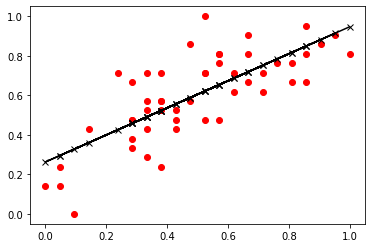

In [12]:
y_pred = model(x_train_bias)
plt.plot(x_train_n, y_train_n, 'ro', label='Original data')
plt.plot(x_train_n, y_pred.data, 'kx-', label='Fitting Line')
plt.show()

### Acessando os parâmetros

In [13]:
w_dic = model.state_dict()
w_dic

OrderedDict([('weight', tensor([[0.2625, 0.6843]]))])

### Parâmetros ótimos, solução analítica

In [14]:
x_bias = x_train_bias
y = y_train_n
x_bias_t = torch.t(x_bias)
w_opt = (torch.inverse(x_bias_t.mm(x_bias)).mm(x_bias_t)).mm(y)
print(torch.t(w_opt))

tensor([[0.2613, 0.6865]])


# Exercícios

- 1) Qual é o shape de `loss`? Por que no final da varredura do laço de treinamento, a perda é impressa utilizando
   `loss.item()`? 
   

- 2) Calcule e imprima o valor da perda (MSE) fazendo o predict da rede com os pesos já
   treinados.

- 3) Crie duas listas `w0_list` e `w1_list` para guardar a evolução dos valores dos
   parâmetros durante o laço de treinamento.
   Modifique o exemplo do gráfico tipo **scatter plot** para visualizar a variação 
   dos parâmetros do modelo duas dimensões. 
   Marque neste gráfico o valor ótimo do parâmetro dado pela solução
   analítica.

## Ploting vectors

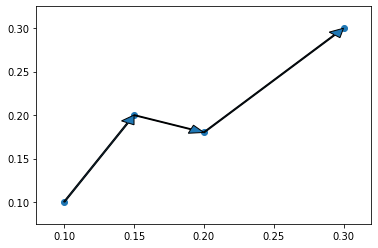

In [15]:
# Exemplo
w0_list = [0.1, 0.15, 0.2, 0.3]
w1_list = [0.1, 0.2, 0.18, 0.3]
plt.scatter(w0_list,w1_list)
w0_old = None
for (w0,w1) in zip(w0_list,w1_list):
    if w0_old:
        plt.arrow(w0_old, w1_old, w0-w0_old, w1-w1_old,
                  head_length=0.01,head_width=0.01,shape='full',
                  length_includes_head=True)
    w0_old,w1_old = w0,w1


# Aprendizados